In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GroupKFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)



In [2]:
df_train = pd.read_csv("C:\\Users\\dipes\\Desktop\\election-analytics-nepal-2082\\data\\processed\\training_pr_base.csv")


In [3]:
df = df_train.copy()

# Sanity
assert "vote_share_change" in df.columns
assert "vote_share_lag" in df.columns


In [51]:
df["under_40_ratio"] = df["age_18-29_ratio"] + df["age_30-39_ratio"]
df["40-60_ratio"] = df["age_40-49_ratio"] + df["age_50-59_ratio"]
df["SEE-Inter"] = df["SLC or SEE % 2078"]+df["Intermediate & equivalent % 2078"]
df["Grad+"] = df["Graduate & equivalent % 2078"]+df["Post graduate equivalent & above % 2078"]

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3619 entries, 0 to 3618
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   district_id                              3619 non-null   int64  
 1   party_id                                 3619 non-null   object 
 2   election_year                            3619 non-null   int64  
 3   vote_share                               3619 non-null   float64
 4   vote_share_lag                           3619 non-null   float64
 5   vote_share_change                        3619 non-null   float64
 6   is_new_party                             3619 non-null   int64  
 7   Absent rate within country 2078          3619 non-null   float64
 8   Absent rate abroad 2078                  3619 non-null   float64
 9   Literacy Rate 2078                       3619 non-null   float64
 10  Primary Education % 2078                 3619 no

In [83]:
df.head()
FEATURES = [
    # Political inertia
    "vote_share_lag",
    "is_new_party",
    "IS_Major?",
    "Was_Part_Of_Ousted_Government?",
    "GenZ_and_Youth_Favored?",
    "IS_ALTERNATIVE_FORCE?",

    # Demographics (compressed)
    "under_40_ratio",
    "40-60_ratio",
    "female_ratio",

    # Education (high signal only)
    "Literacy Rate 2078",
    "SEE-Inter",
    "Grad+",

    # Migration
    "Absent rate within country 2078",
    "Absent rate abroad 2078",

    # Mobilization
    "valid_turnout",
    "valid_turnout_lag",

    # Digital
    "leader_following_log",
]
TARGET = "vote_share_change"

In [84]:
groups = df["district_id"]
X = df[FEATURES]
y = df[TARGET]

In [85]:
model = Ridge(alpha=1.0)

In [86]:
gkf = GroupKFold(n_splits=2)

oof_preds = np.zeros(len(df))

for train_idx, val_idx in gkf.split(X, y, groups):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(X_train, y_train)
    oof_preds[val_idx] = model.predict(X_val)


In [87]:
mae = mean_absolute_error(y, oof_preds)
rmse = np.sqrt(mean_squared_error(y, oof_preds))

print(f"MAE (vote_share_change): {mae:.3f}")
print(f"RMSE (vote_share_change): {rmse:.3f}")


MAE (vote_share_change): 0.842
RMSE (vote_share_change): 2.293


In [88]:
df["pred_vote_share"] = (
    df["vote_share_lag"] + oof_preds
).clip(0, 100)


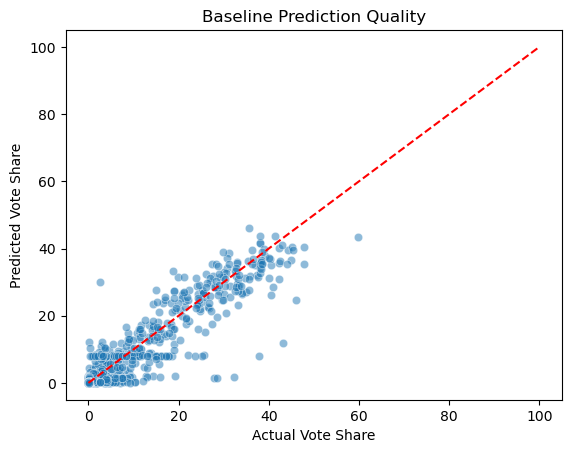

In [89]:
sns.scatterplot(
    x=df["vote_share"],
    y=df["pred_vote_share"],
    alpha=0.5
)
plt.plot([0,100],[0,100], 'r--')
plt.xlabel("Actual Vote Share")
plt.ylabel("Predicted Vote Share")
plt.title("Baseline Prediction Quality")
plt.show()


In [90]:
coef_df = pd.DataFrame({
    "feature": FEATURES,
    "coef": model.coef_
}).sort_values("coef", ascending=False)

coef_df


,feature,coef
4,GenZ_and_Youth_Favored?,6.430530
3,Was_Part_Of_Ousted_Government?,0.625269
1,is_new_party,0.316132
16,leader_following_log,0.274696
11,Grad+,0.013685
14,valid_turnout,0.005859
10,SEE-Inter,0.005481
13,Absent rate abroad 2078,0.004010
12,Absent rate within country 2078,-0.005321
15,valid_turnout_lag,-0.009047


In [91]:
df82 = pd.read_csv("C:\\Users\\dipes\\Desktop\\election-analytics-nepal-2082\\data\\processed\\base_pr_2082.csv")

In [92]:
temp = df[["district_id","valid_turnout"]].drop_duplicates().reset_index(drop =True)

In [93]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   district_id    77 non-null     int64  
 1   valid_turnout  77 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.3 KB


In [94]:
df82 = df82.merge(temp,on = "district_id", how = "left")

In [95]:
df82["under_40_ratio"] = df82["age_18-29_ratio"] + df82["age_30-39_ratio"]
df82["40-60_ratio"] = df82["age_40-49_ratio"] + df82["age_50-59_ratio"]
df82["SEE-Inter"] = df82["SLC or SEE % 2078"]+df82["Intermediate & equivalent % 2078"]
df82["Grad+"] = df82["Graduate & equivalent % 2078"]+df82["Post graduate equivalent & above % 2078"]

In [96]:
X_82 = df82[FEATURES]

In [97]:
base_model = model.fit(X, y)

In [98]:
df82["pred_vote_share"] = df82["vote_share_lag"] + base_model.predict(X_82)

In [99]:
temp2 = df82[["party_id","district_id","total_voters","valid_turnout","vote_share_lag","pred_vote_share"]]

In [100]:
temp2["Votes"] = temp2["total_voters"]*temp2["valid_turnout"]*temp2["pred_vote_share"]/10000

C:\Users\dipes\AppData\Local\Temp\ipykernel_15648\1858784566.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2["Votes"] = temp2["total_voters"]*temp2["valid_turnout"]*temp2["pred_vote_share"]/10000


In [101]:
temp3 = (
    temp2[['party_id', 'Votes']]
    .groupby('party_id', as_index=False)['Votes']
    .sum()
    .sort_values('Votes', ascending=False)
)

In [102]:
temp3.head(20)

,party_id,Votes
0,P001,2.597734e+06
1,P002,2.486502e+06
3,P004,1.819699e+06
2,P003,1.398425e+06
44,P046,9.106245e+05
55,P057,8.561028e+05
4,P005,6.782481e+05
6,P007,4.513290e+05
5,P006,4.123891e+05
7,P009,3.558105e+05
